In [2]:
%pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
from probs.gptb import GPTBForCausalLM, GPTBConfig
from probs.gptb import ByteTokenizer

tokenizer = ByteTokenizer()


2025-03-03 16:07:19.956272: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 16:07:20.130197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 16:07:20.207526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 16:07:20.227652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 16:07:20.361718: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import torch

# Simple collation for fixed-size batches (adjust padding as needed).
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    # Pad the sequences to the same length.
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = (input_ids != 0).long()
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": input_ids}

def tokenize_fn(example):
    tokens = tokenizer(example["text"])
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

In [5]:

from datasets import Dataset,DatasetDict

def get_local_dataset():

    # load our custom dataset
    # path : ~/code/pst/raw/2020/*.txt

    import os
    import glob

    def load_text_files(path):
        texts = []
        for file_path in glob.glob(path):
            with open(file_path, "r") as f:
                texts.append(f.read())
        return texts

    dummy_texts = load_text_files("/home/pkd/code/pst/raw/2020/*.txt")

    # split into 1024 bytes sections
    def split_text(text, chunk_size=512):
        return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    dummy_texts = [split_text(text) for text in dummy_texts]
    dummy_texts = [item for sublist in dummy_texts for item in sublist]




    # Create a Hugging Face Dataset from the list of sentences.
    dummy_dataset = Dataset.from_dict({"text": dummy_texts})

    # Assume you have a tokenizer (for instance, from your GPTB model).
    # tokenizer should be a callable that takes text and returns a dict with "input_ids" and "attention_mask".
    def tokenize_fn(example):
        tokens = tokenizer(example["text"])
        return {
            "input_ids": tokens["input_ids"],
            "attention_mask": tokens["attention_mask"]
        }

    tokenized_dataset = dummy_dataset.map(tokenize_fn, batched=False)
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

    return DatasetDict({
        "train": tokenized_dataset
    })

def get_hf_dataset():
    # Load dataset
    from datasets import load_dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

    # Function to split text into chunks
    def split_text(examples):
        chunk_size = 512  # Character-based splitting (adjust if needed)
        all_chunks = []
        for text in examples["text"]:
            # Split text into chunks
            chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
            # Filter out empty chunks
            chunks = [chunk for chunk in chunks if chunk.strip()]
            all_chunks.extend(chunks)
        return {"text": all_chunks}

    # Apply splitting to each dataset split using batched processing for efficiency
    dataset = dataset.map(split_text, batched=True, batch_size=1000)

    # Tokenization function


    # Tokenize the dataset
    tokenized_dataset = dataset.map(tokenize_fn, batched=True)

    # Set dataset format to PyTorch tensors
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

    return tokenized_dataset


dataset="local"

tokenized_dataset = None
if dataset == "local":
    tokenized_dataset = get_local_dataset()
else:
    tokenized_dataset = get_hf_dataset()

train_tokenized_dataset = tokenized_dataset["train"]



Map:   0%|          | 0/7982 [00:00<?, ? examples/s]

In [7]:
# write some code to test cuda
import torch
from torch.utils.data import DataLoader

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")



config = GPTBConfig(
    vocab_size=265,        # Vocabulary size of GPT-2 tokenizer
    n_positions=1024,        # Maximum sequence length GPT-2 handles
    n_ctx=1024,              # Context size (usually the same as n_positions)
    n_embd=768,              # Embedding size
    n_layer=18,              # Number of transformer layers
    n_head=16,               # Number of attention heads
    activation_function='gelu_new',  # Activation function used by GPT-2
    resid_pdrop=0.1,         # Residual dropout
    embd_pdrop=0.1,          # Embedding dropout
    attn_pdrop=0.1,          # Attention dropout
    layer_norm_epsilon=1e-5, # Epsilon for layer normalization
    initializer_range=0.02,  # Standard deviation for weight initialization
    bos_token_id=256,      # Beginning-of-sentence token ID
    eos_token_id=256       # End-of-sentence token ID
)

size = 100

train_tokenized_dataset = train_tokenized_dataset.select(range(size))

# Create DataLoader for the training split
train_loader = DataLoader(
    train_tokenized_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)




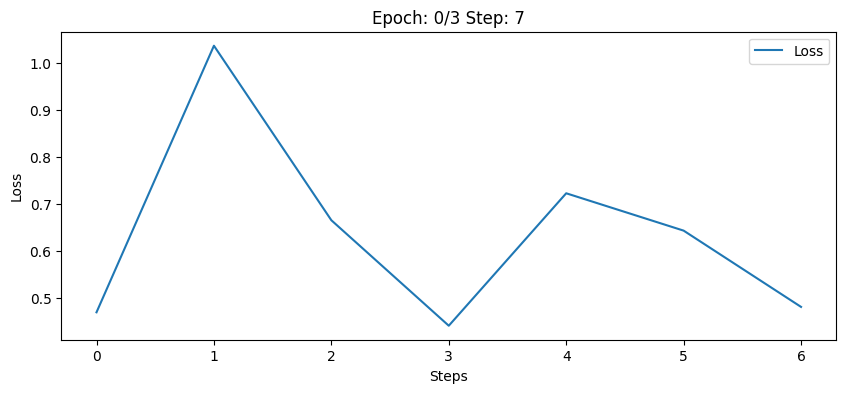

KeyboardInterrupt: 

: 

In [ ]:
import os

os.environ["AMD_SERIALIZE_KERNEL"] = "3"

import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(device)

# Verify vocabulary size matches tokenizer
print(f"Model vocab size: {config.vocab_size}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")  # Add your tokenizer reference

if model is None:
    model = GPTBForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

epochs = 3
loss_history = []
global_step = 0

loss_fn = torch.nn.CrossEntropyLoss()


for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}")
    model.train()
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc="Training")
    for batch in progress:
        optimizer.zero_grad()

        # Move batch to device with validation
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["input_ids"]  # Auto-regressive LM uses input_ids as labels
        )

        logits = outputs.logits  # assuming your model outputs logits in 'outputs.logits'
        # Flatten logits and labels for cross-entropy
        loss = loss_fn(logits.view(-1, logits.size(-1)), batch["input_ids"].view(-1))

        # Check for NaN/Inf in loss
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError("NaN/Inf detected in loss")

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        epoch_loss += loss_value
        loss_history.append(loss_value)
        global_step += 1

        progress.set_postfix(loss=loss_value)

        # Update dynamic plot every 10 steps
        if global_step % 1 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 4))
            plt.plot(loss_history, label="Loss")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.title(f"Epoch: {epoch}/{epochs} Step: {global_step}")
            plt.legend()
            plt.show()

    print(f"Epoch {epoch+1} Loss:", epoch_loss / len(train_loader))
    model.save_pretrained("gptb")

In [ ]:
model.model.save_pretrained("gptb",push_to_hub=True)

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

In [8]:
# Load the model
model = GPTBForCausalLM.from_pretrained("./gptb").to(device)

Token: I Probs: tensor([3.5474e-08, 3.5423e-08, 3.7606e-08, 4.1419e-08, 3.9251e-08, 4.3927e-08,
        3.8940e-08, 3.8311e-08, 3.8057e-08, 4.4003e-08, 7.1978e-06, 4.0752e-08,
        3.0240e-08, 3.8226e-08, 3.3667e-08, 4.1296e-08, 4.1746e-08, 3.9478e-08,
        4.4606e-08, 3.6083e-08, 3.7385e-08, 3.3545e-08, 4.1852e-08, 3.9956e-08,
        3.6897e-08, 3.9387e-08, 4.1452e-08, 4.2311e-08, 4.1134e-08, 4.1769e-08,
        3.8234e-08, 3.8409e-08, 9.3854e-03, 3.9892e-05, 3.8172e-08, 4.1629e-08,
        3.5282e-08, 1.0548e-04, 3.0821e-08, 2.6859e-02, 4.2044e-08, 4.3170e-08,
        3.8236e-08, 3.6266e-08, 2.5019e-01, 4.5039e-05, 3.2087e-03, 3.3259e-08,
        4.2802e-05, 2.7744e-05, 1.7416e-05, 1.0804e-03, 1.5205e-04, 1.7382e-04,
        6.1274e-04, 2.8483e-04, 4.0696e-04, 2.5173e-03, 3.9667e-08, 3.3923e-08,
        3.8981e-08, 3.7451e-08, 3.8729e-08, 1.1516e-02, 4.0825e-08, 8.7008e-04,
        6.8560e-04, 8.4879e-04, 4.1491e-05, 3.2355e-04, 2.4068e-05, 1.0630e-04,
        1.3922e-06, 3.49

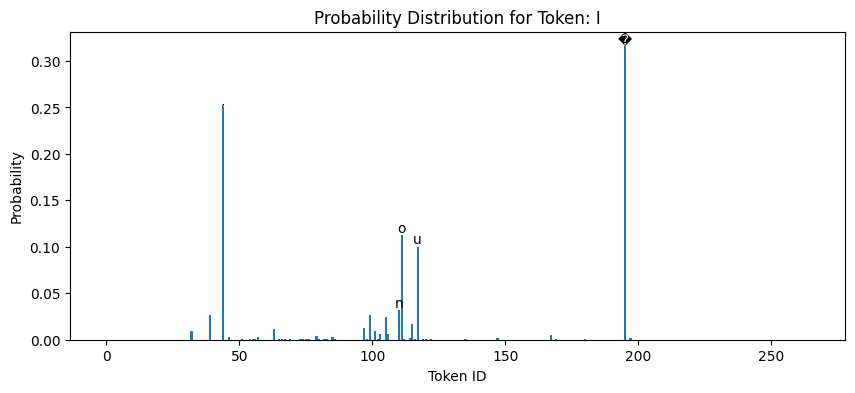

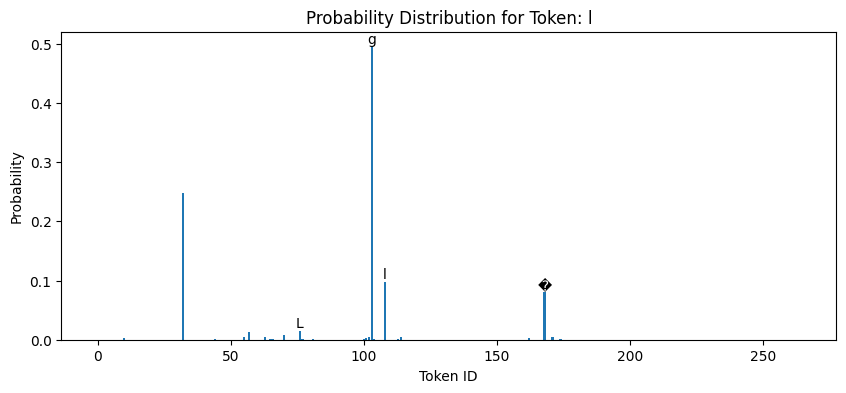

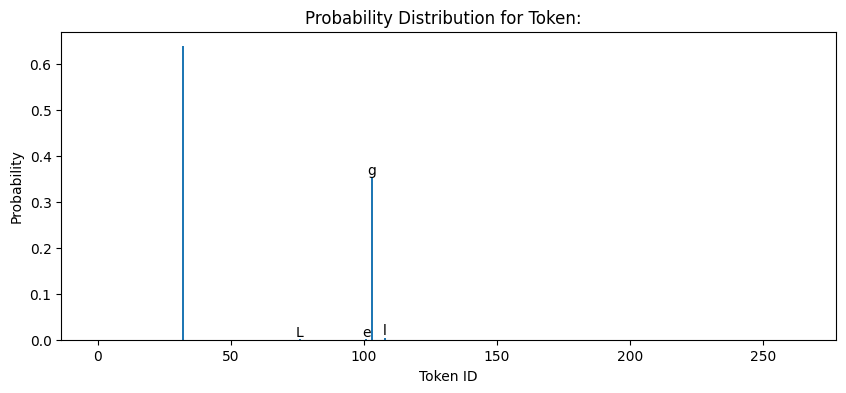

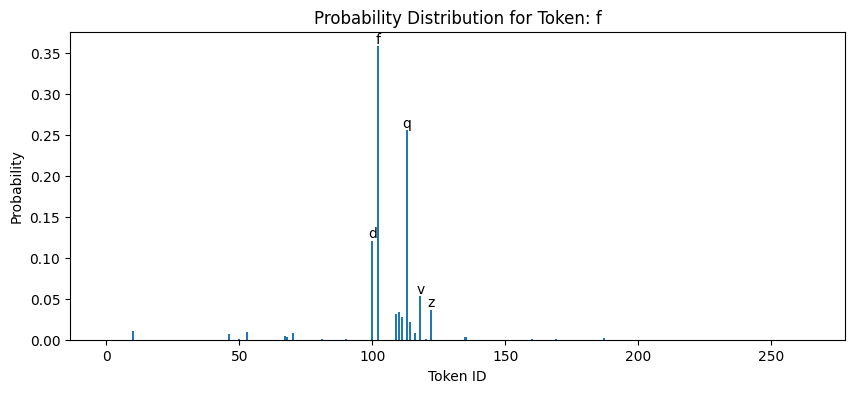

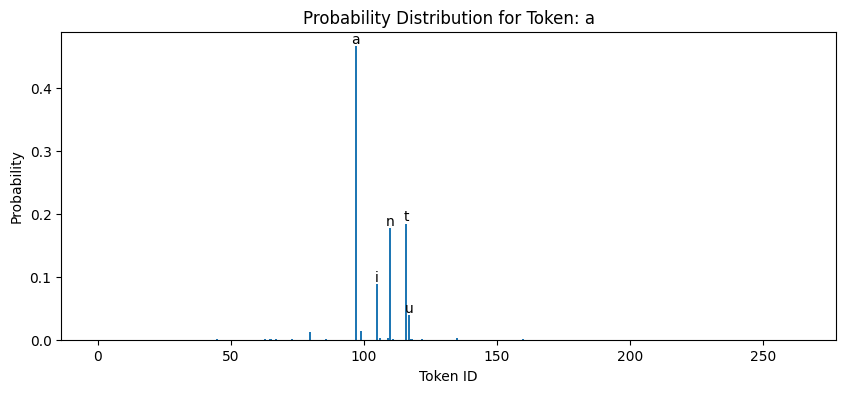

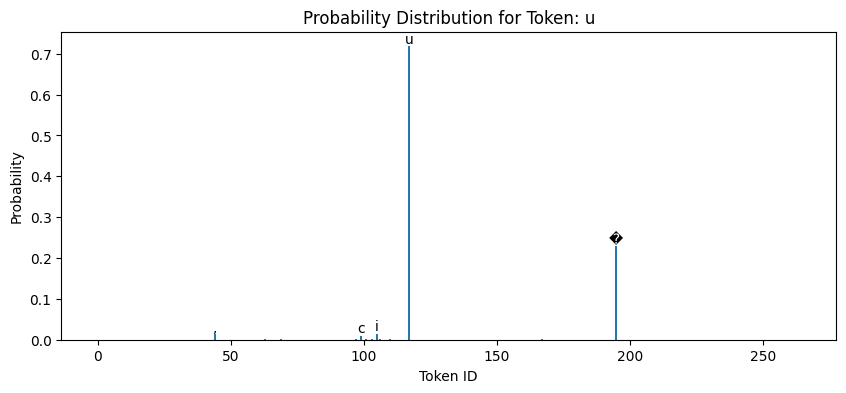

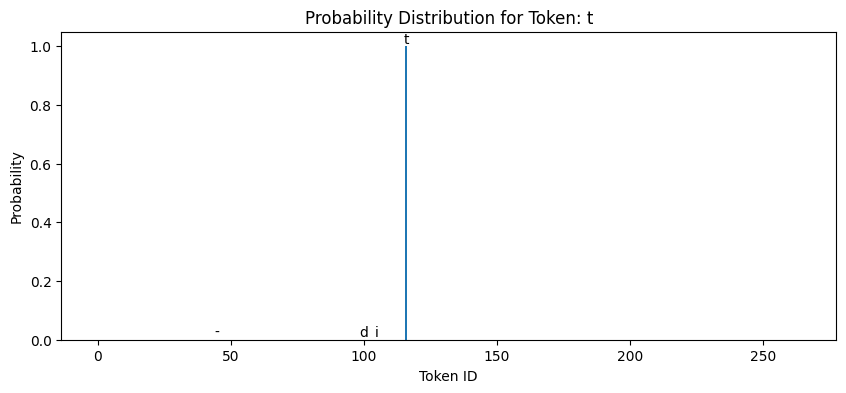

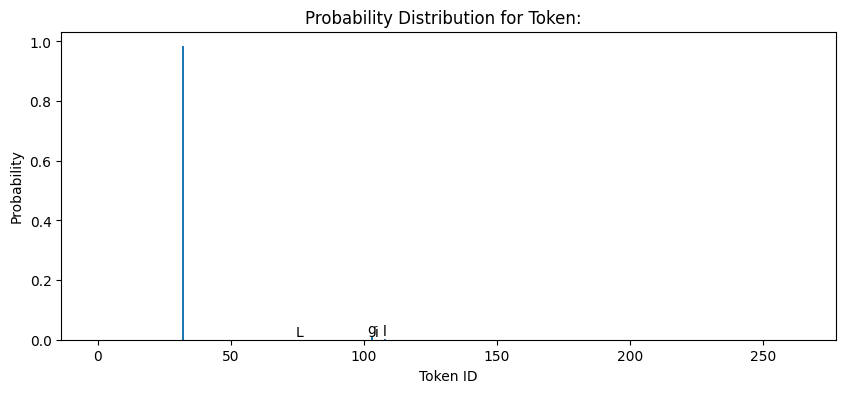

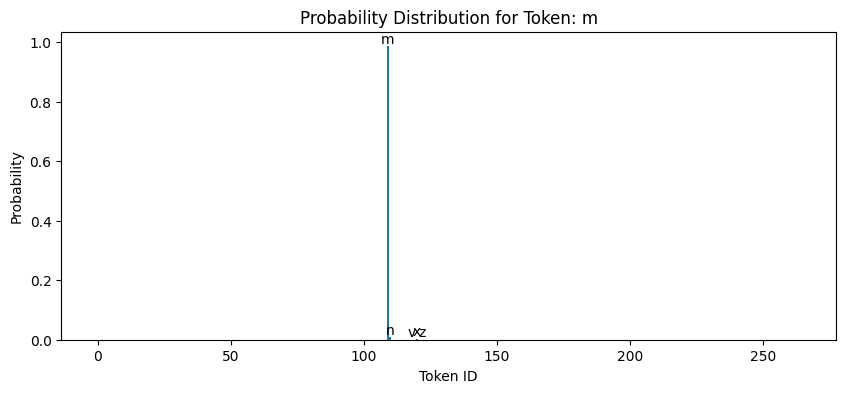

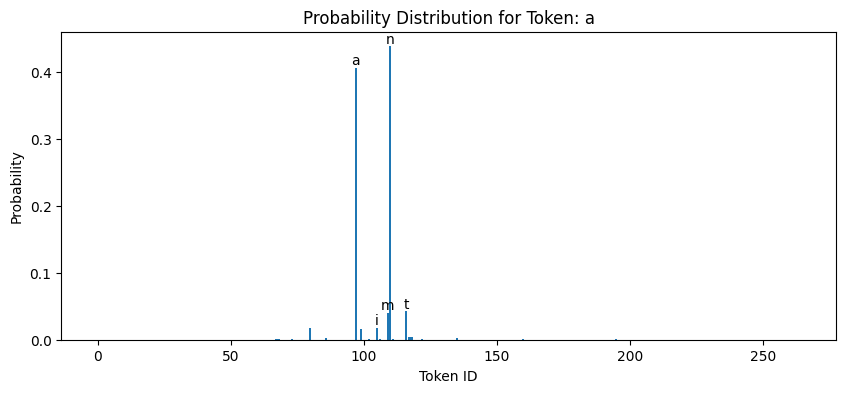

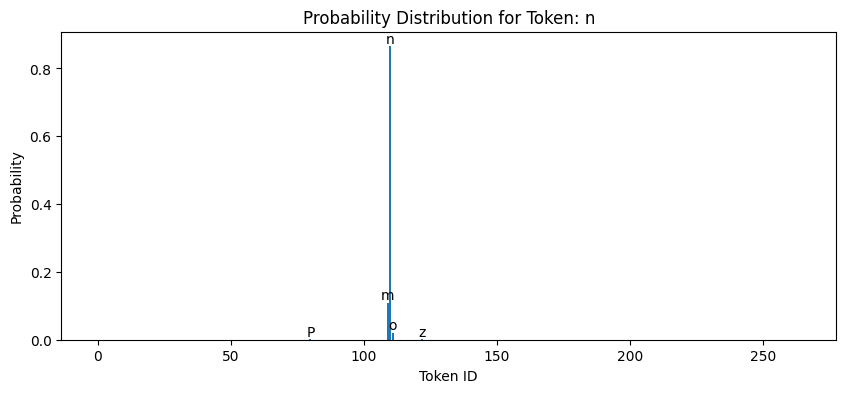

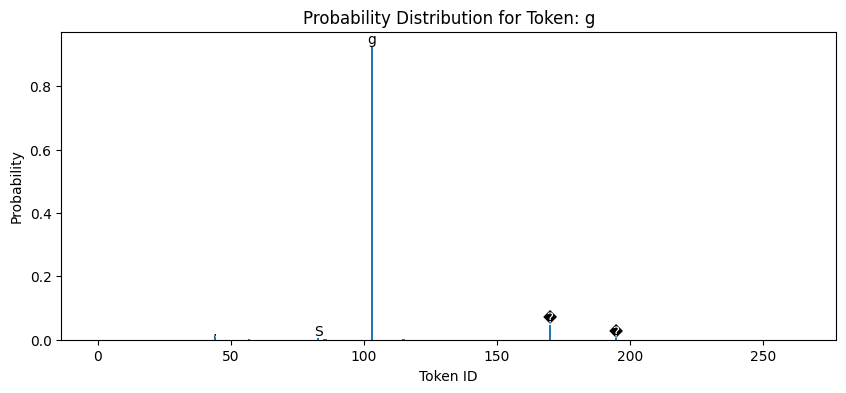

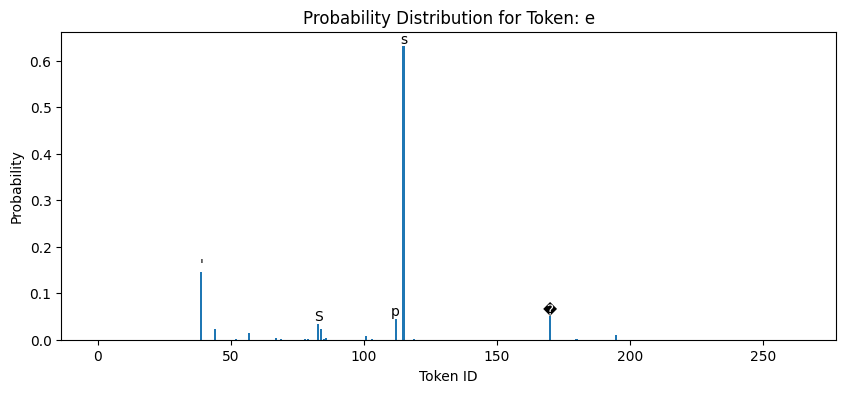

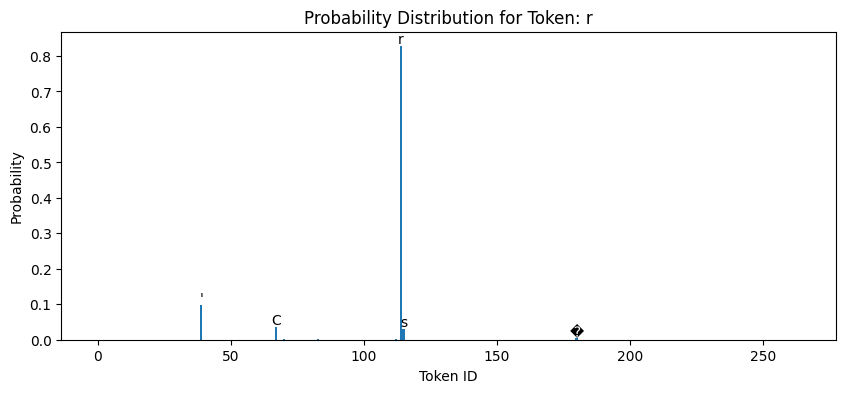

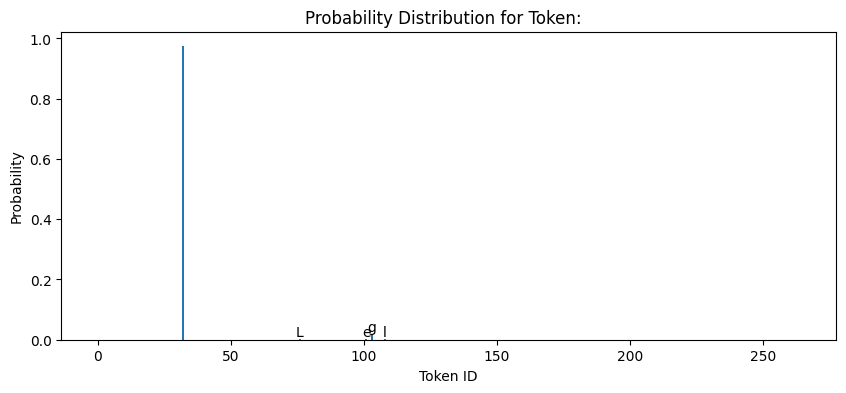

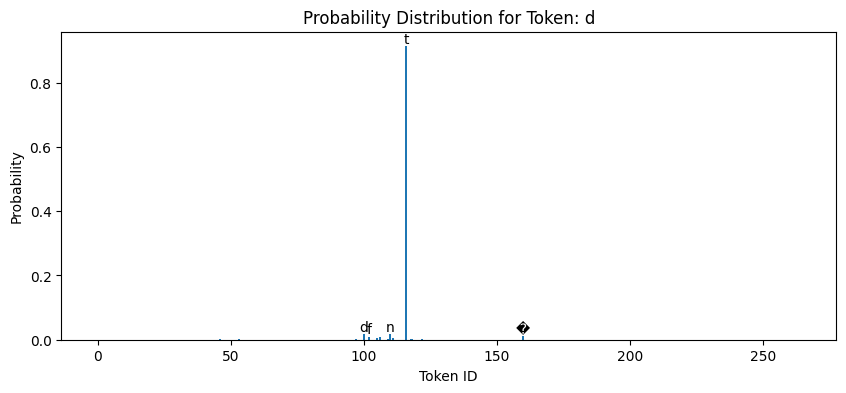

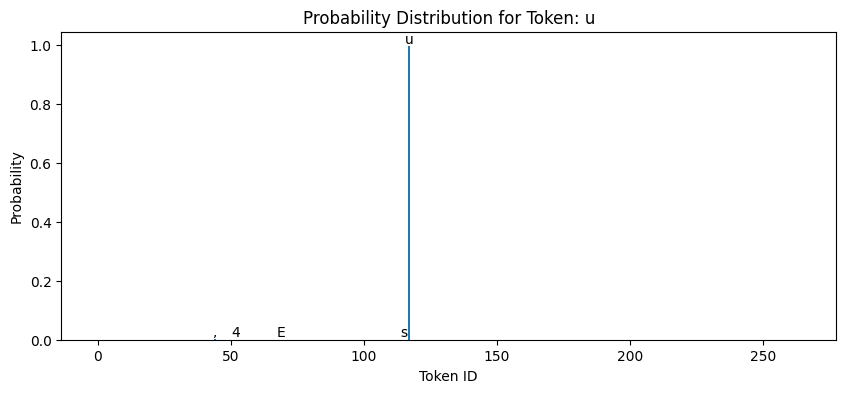

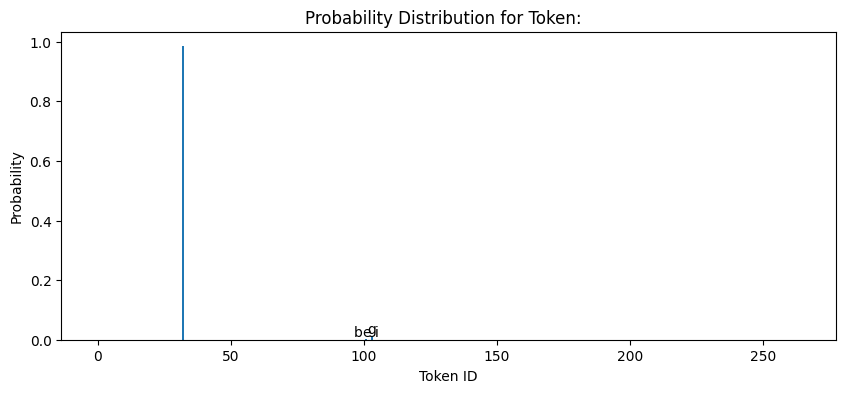

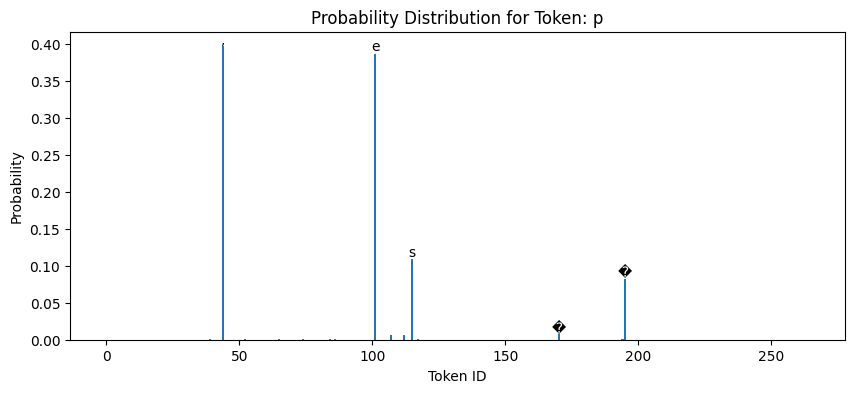

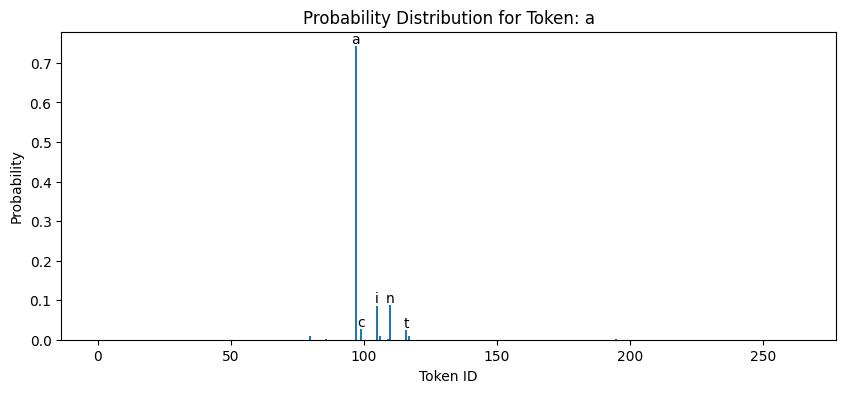

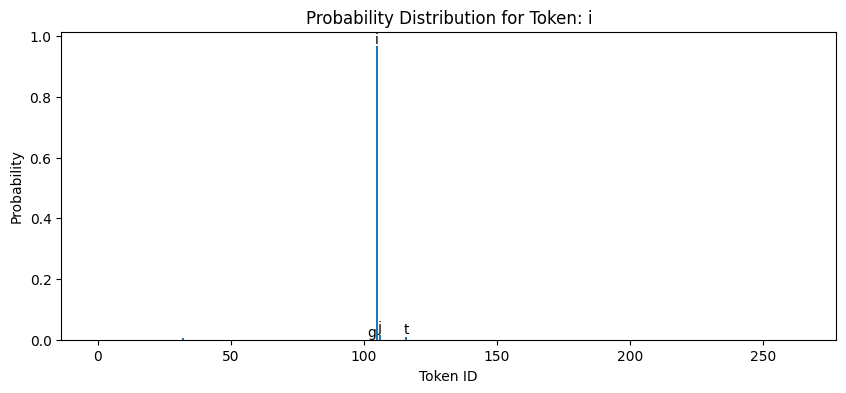

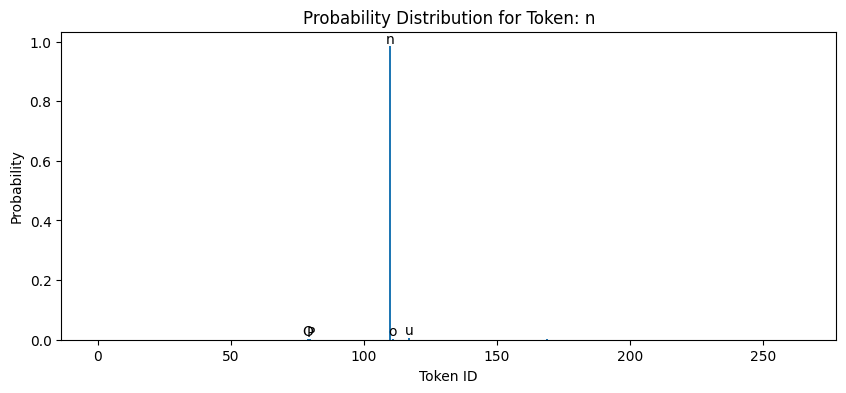

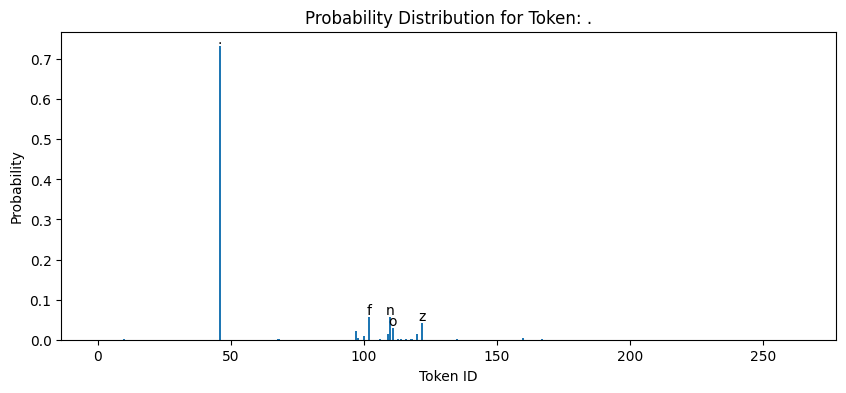

Total Entropy: 25.764751434326172
Total Perplexity: 62.880245208740234


In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
# tokenize the initial input sentence
input_ids = tokenizer("Il faut manger du pain.")["input_ids"]
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

probs = []

# generate probability distributions for all tokens in the input sentence
for i in range(len(input_ids[0])):
    outputs = model(input_ids=input_ids[:, :i+1])
    next_token_logits = outputs.logits[0, -1, :]
    next_token_probs = F.softmax(next_token_logits, dim=-1)
    print("Token:", tokenizer.decode([input_ids[0][i].item()]), "Probs:", next_token_probs)
    probs.append(next_token_probs)

# plot probability distributions
for i, prob in enumerate(probs):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(prob)), prob.cpu().detach().numpy())
    plt.title(f"Probability Distribution for Token: {tokenizer.decode([input_ids[0][i].item()])}")
    plt.xlabel("Token ID")
    plt.ylabel("Probability")

    # Annotate the 5 most important probabilities with their corresponding characters
    top_probs, top_indices = torch.topk(prob, 5)
    for j in range(5):
        plt.text(top_indices[j].item(), top_probs[j].item(), tokenizer.decode([top_indices[j].item()]), ha='center', va='bottom')

    plt.show()

# analyze entropy and perplexity
total_entropy = 0.0
total_perplexity = 0.0
for prob in probs:
    entropy = -torch.sum(prob * torch.log2(prob))
    perplexity = 2 ** entropy
    total_entropy += entropy
    total_perplexity += perplexity

print("Total Entropy:", total_entropy.item())
print("Total Perplexity:", total_perplexity.item())


In [16]:
# try some completion with our model

to_complete = "Je suis "


input_ids = tokenizer(to_complete)["input_ids"]
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
outputs = model.generate(input_ids, max_length=100, do_sample=True, temperature=0.7)
completion = tokenizer.decode(outputs[0])
print(completion)

bad_model = GPTBForCausalLM(config).to(device)

bad_outputs = bad_model.generate(input_ids, max_length=100, do_sample=True, temperature=0.7)
bad_completion = tokenizer.decode(bad_outputs[0])
print(bad_completion)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Je suis             iitnnnnnnnnnnoooooooommmmnnnnnnooonnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnuuuuuuu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


>���%b�e�Q��p�� s�*���Q���u�Q���$,� $***
